In [1]:
using LinearAlgebra, Statistics
using TextAnalysis, ExcelReaders, StringDistances, AMD, SparseArrays, Plots
cd(@__DIR__)

┌ Info: Recompiling stale cache file /local/home/fredrikb/.julia/compiled/v1.0/TextAnalysis/5Mwet.ji for TextAnalysis [a2db99b7-8b79-58f8-94bf-bbc811eef33d]
└ @ Base loading.jl:1184


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2223c9d4e93eca5b9a9c0c8301a6bcb2bbfcc143-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2223c9d4e93eca5b9a9c0c8301a6bcb2bbfcc143-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

loaded


Literate.notebook("MatchScholars.jl", ".", documenter=false, execute=false)
This script analyzes the abstracts published by the department of automatic control, Lund University, and looks for similarities amngost the abstracts of the visiting scholars of the LCCC focus period
The department abstract and authornames were acuired from https://lup.lub.lu.se/search/publication?q=department+exact+v1000253 and exported as an excel file [publications.xsl](publications.xsl). The abstracts of the visiting scolars are provided in [visitors.txt](visitors.txt)

# Read department data

In [5]:
filename  = "publications.xls"
authors   = readxl(filename, "Sheet1!E2:E1501")[:]
abstracts = readxl(filename, "Sheet1!X2:X1501")[:];

Filter the data to only keep valid names and abstracts

In [6]:
valid_authors   = isa.(authors,String)
authors         = authors[valid_authors]
abstracts       = abstracts[valid_authors]

valid_abstracts = isa.(abstracts,String)
authors         = authors[valid_abstracts]
abstracts       = abstracts[valid_abstracts];

Some abstracts are in Swedish, we get rid of those

In [7]:
valid_abstracts = [match(r"ENG", a) != nothing && match(r"och", a) == nothing for a in abstracts]
authors         = authors[valid_abstracts]
abstracts       = abstracts[valid_abstracts];

Clean data

In [8]:
authors   = [replace(a, r"\([\w-]+\)" => "") for a in authors]
abstracts = [replace(a, r"\([\w-]+\)" => "") for a in abstracts]
abstracts = [replace(a, r"ENG:"       => "") for a in abstracts]
@assert length(authors) == length(abstracts)

# Read visitor data

In [9]:
visitortext = readlines("visitors.txt")
visitors = map(visitortext) do v
    m = match(r"==name== (.+)$", v)
    if m == nothing
        return m
    end
    String(m.captures[1])
end
visitors = String.(filter!(x->x!=nothing, visitors))

19-element Array{String,1}:
 "Maximiliam Karl"             
 "Roshan Shariff"              
 "Joel Sjöbom"                 
 "Anahita Jamshidnejad"        
 "Miriam Zacksenhouse"         
 "Farnaz Adib Yaghmaie"        
 "Ekin Basalp"                 
 "Zhongqi Sun"                 
 "Yu Kawano"                   
 "Adrianna R. Loback"          
 "Natalia Martina López Celani"
 "Shreya Saxena"               
 "Thiago Marinho"              
 "Ehsan Nekouei"               
 "Jack Umenberger"             
 "Yorie Nakahira"              
 "Alberto Padoan"              
 "Felix Kong"                  
 "Eike Petersen"               

Assemble the abstract from individual lines

In [10]:
function build_abstract(lines, abstract="", abstracts=String[])
    if length(lines) < 1
        push!(abstracts, abstract)
        return abstracts
    end
    if match(r"==name==", lines[1]) != nothing # Found new name
        push!(abstracts, abstract)
        return build_abstract(lines[2:end], "", abstracts)
    end
    return build_abstract(lines[2:end], abstract*" "*lines[1], abstracts)
end
visitor_abstracts = build_abstract(visitortext)[2:end];

Prepare data for text analysis

In [11]:
docs = StringDocument.([deepcopy(abstracts); deepcopy(visitor_abstracts)])
crps = Corpus(deepcopy(docs))
prepare!(crps, strip_corrupt_utf8 | strip_case | strip_articles | strip_prepositions | strip_pronouns | strip_stopwords | strip_whitespace | strip_non_letters | strip_numbers)
remove_words!(crps, ["br"]) # For some reason the word "br" appeas very often (html tag?)
update_lexicon!(crps)

# Analysis
We will perform two sets of analysis, [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) and [Latent Semantic Analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis)
LDA

In [12]:
m     = DocumentTermMatrix(crps)
k     = 6    # number of topics
iters = 1000 # number of gibbs sampling iterss
α     = 1/k  # hyper parameter topics per document
β     = 0.01 # hyper parameter words per topic
ϕ,θ   = lda(m, k, iters, α, β) # ϕ: topics × words θ: topics × documents
println("Occupancy: ", sum(ϕ.!=0)/length(ϕ))

Occupancy: 0.30319869343530914


Calculate a topic matrix if you want to inspect the found topics

In [13]:
k_largest(array,k) = sortperm(array, rev=true)[1:k]
words_per_topic = 20
topics = map(1:k) do topic_num
    probs = Vector(ϕ[topic_num,:])
    inds_of_largest = k_largest(probs,words_per_topic)
    words = m.terms[inds_of_largest]
    words
end
topics = hcat(topics...)

20×6 Array{String,2}:
 "systems"       "control"       …  "control"      "glucose"       
 "control"       "time"             "robot"        "models"        
 "linear"        "systems"          "force"        "control"       
 "time"          "system"           "based"        "modelica"      
 "model"         "performance"      "model"        "paper"         
 "system"        "paper"         …  "using"        "insulin"       
 "optimal"       "real"             "system"       "based"         
 "paper"         "applications"     "industrial"   "optimization"  
 "feedback"      "based"            "estimation"   "model"         
 "stability"     "resource"         "method"       "data"          
 "optimization"  "design"        …  "robots"       "language"      
 "based"         "software"         "motion"       "students"      
 "method"        "application"      "paper"        "blood"         
 "function"      "scheduling"       "results"      "tools"         
 "using"         "model"  

`topics` is now a matrix where each column consists of the 20 most prominent words in each topic
We can also define some interesting covaiance matrices for visualization (plots omitted)

In [14]:
topic_covariance_by_words     = Matrix(ϕ*ϕ')
topic_covariance_by_documents = Matrix(θ*θ')
document_covariance           = θ'θ;

We now conduct some tedious coding to associate the authors of the abstracts in the publication database with the current staff members

In [15]:
individual_authors = String.(strip.(vcat(split.(authors, ";")...)))
unique_authors     = unique(individual_authors)
author_mapping = map(unique_authors) do ua
    [match(Regex(ua), aa) != nothing for aa in authors]
end
author_mapping = findall.(author_mapping)
author_rank    = sortperm(length.(author_mapping), rev=true)
top_10_authors = unique_authors[author_rank[1:10]]

10-element Array{String,1}:
 "Johansson, R."     
 "Johansson, Rolf"   
 "Robertsson, A."    
 "Robertsson, Anders"
 "Rantzer, Anders"   
 "Årzén, Karl-Erik"  
 "Hägglund, Tore"    
 "Cervin, Anton"     
 "Åkesson, Johan"    
 "Åström, Karl"      

The current staff at the department is listed in [staff.txt](staff.txt)
Since the names of the authors are not on the same format in the database and on the webpage, we use a [string comparison tool](https://github.com/matthieugomez/StringDistances.jl) to find correspondences.
"The distance Tokenmax(RatcliffObershelp()) is a good choice to link names or adresses across datasets."

In [17]:
staff = readlines("staff.txt")

staff2unique_author = map(staff) do staffi
    distances = map(unique_authors) do authori
        StringDistances.compare(TokenMax(RatcliffObershelp()), filter(isascii,authori), filter(isascii,staffi))
    end
    max_i = argmax(distances)
    distances[max_i] < 0.9 && return 0
    return max_i
end
filter!(!iszero, staff2unique_author)
staff_authorname = unique_authors[staff2unique_author]

document_indices_of_staff = map(staff_authorname) do staffi
    r = Regex(staffi)
    present = map(authors) do authori
        match(r, authori) != nothing
    end
    findall(present)
    end;

To find the topic vectors of each staff members, we average over all their publications. This is a simple way of doing things, but might cause a senior author with a diverse set of publications to appear as having little similarity with a young researcher with a narrow focus, even if the senior author has a few publications in that particular topic.

In [18]:
staff_vectors = map(document_indices_of_staff) do staffdocinds
    # ϕ: topics × words   θ: topics × documents
    mean(θ[:,staffdocinds], dims=2)
end
staff_vectors = hcat(staff_vectors...) # n_topics × n_staff

6×38 Array{Float64,2}:
 0.0447061  0.228353   0.577157    …  0.0      0.0  0.497093   0.585483 
 0.65673    0.104189   0.0707304      0.79558  1.0  0.252907   0.0244444
 0.0718739  0.368876   0.0628418      0.0      0.0  0.151685   0.353614 
 0.0102843  0.0164903  0.0485736      0.0      0.0  0.0674157  0.0      
 0.0711715  0.134995   0.233745       0.20442  0.0  0.0        0.0364583
 0.145235   0.147095   0.00695187  …  0.0      0.0  0.0308989  0.0      

The vectors of the visiting scholars are easy to find since they have only a single abstract each

In [19]:
visitor_vectors = θ[:,end-length(visitors)+1:end] # n_topics × n_visitors

6×19 Array{Float64,2}:
 0.178571  0.333333  0.0  0.542857  …  0.0       1.0  0.218182  0.0     
 0.416667  0.666667  0.0  0.457143     0.514706  0.0  0.0       0.0     
 0.0       0.0       0.0  0.0          0.0       0.0  0.0       0.0     
 0.0       0.0       0.0  0.0          0.485294  0.0  0.0       0.0     
 0.404762  0.0       0.0  0.0          0.0       0.0  0.781818  0.327189
 0.0       0.0       1.0  0.0       …  0.0       0.0  0.0       0.672811

The correlation between the abstracts of the staff and the abstracts of the visiting scholars are given by the inner product of their respective topic vectors

In [20]:
visitor_staff_covariance = staff_vectors'visitor_vectors;

Before we plot the covariance matrix, we try to approximately diagonalize it using the [AMD algorithm](https://github.com/JuliaSmoothOptimizers/AMD.jl). To do this, we have to set some elements that fall beneath a certain threshold to zero. We plot a histogram to assist us in setting this threshold

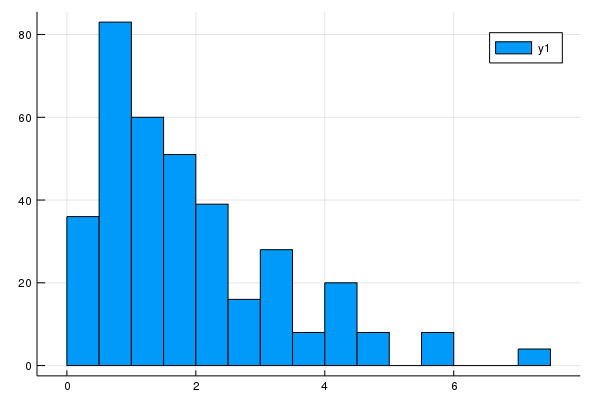

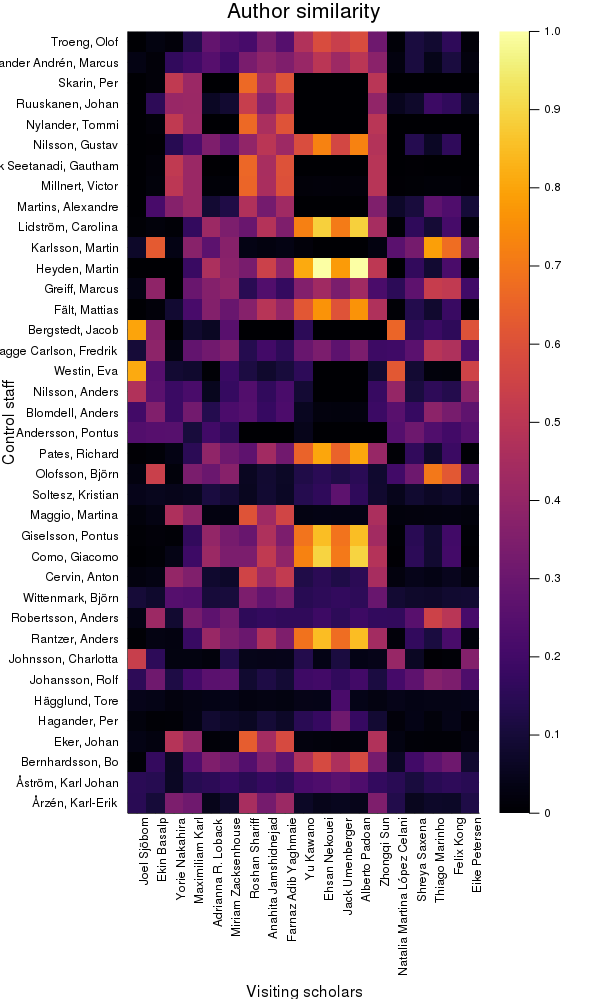

In [21]:
function diagonalize(C, tol; permute_y=false, doplot=true)
    C = copy(C)
    # amdmat = size(C,1) == size(C,2) ? C : C'C
    amdmat = C'C
    doplot && (histogram(abs.(amdmat[:])) |> display)
    amdmat[abs.(amdmat) .< tol] .= 0
    permutation = amd(sparse(amdmat))
    ypermutation = permute_y ? permutation : 1:size(C,1)
    C[ypermutation,permutation], permutation, ypermutation
end
function plotcovariance(C, xvector, yvector; kwargs...)
    xticks = (1:length(xvector), xvector)
    yticks = (1:length(yvector), yvector)
    heatmap(C; xticks=xticks, yticks=yticks, xrotation=90, title="Author similarity", kwargs...)
end

C, permutation, ypermutation = diagonalize(visitor_staff_covariance, 2.5, permute_y=false)
plotcovariance(C, visitors[permutation], staff_authorname[ypermutation], xlabel="Visiting scholars", ylabel="Control staff", size=(600,1000))

We can do the same analysis amngost the staff members

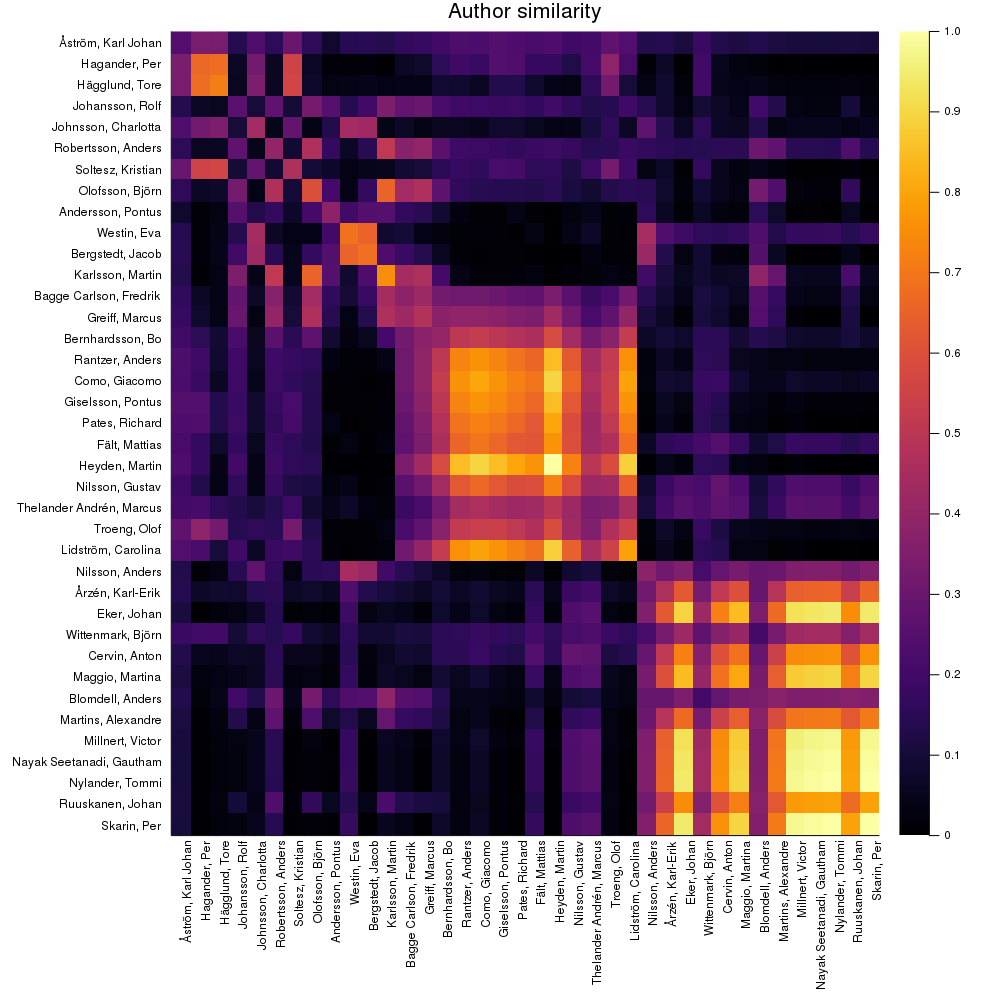

In [23]:
staff_covariance = staff_vectors'staff_vectors
C, permutation, ypermutation = diagonalize(staff_covariance, 2.9, permute_y=true, doplot=false)
plotcovariance(C,staff_authorname[permutation],staff_authorname[permutation], xrotation=90, size=(1000,1000), yflip=true)


WebIO.webio_serve(page("/", req -> ui), 8000)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*